In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torchvision
from torchvision import transforms as T
import torch.nn as nn
import torch.nn.functional as nnF
import data_loader
from PIL import Image

In [17]:
#Import and initialize dataloaders
train_loader, val_loader, test_loader = data_loader.get_dataloader(path="C:/Users/colef/OneDrive - University of Miami/Documents/College/Spring 2024/ML/hws/hw5s/COVID19CTS224/S224/")

In [218]:
#Create model
class FeatureExtractorNetwork(nn.Module):
    def __init__(self, model):
        super(FeatureExtractorNetwork, self).__init__()
        
        #Feature extractor
        self.features = nn.Sequential(*list(model.children())[:-1])
        self.features.trainable = False
        layers = list(model.children())
        features = layers[-1].in_features
        self.flatten = nn.Flatten()
        
        #Fully connected layers
        self.fc1 = nn.Linear(features, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = nnF.tanh(self.fc1(x))
        x = nnF.tanh(self.fc2(x))
        x = nnF.sigmoid(self.fc3(x))
        return x

In [220]:
#Check that model runs on a random tensor
model = FeatureExtractorNetwork(torchvision.models.resnet18())
x=torch.randn(1,3,224,224)
x = model(x)
print(x)

tensor([[0.5213]], grad_fn=<SigmoidBackward0>)


In [221]:
#Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [222]:
#Define training function
def train(model,optimizer,train_dataloader,val_dataloader,criterion):
    #Set model to training mode
    model.train()
    
    #Initialize loss and accuracy
    train_loss = 0
    train_accuracy = 0
    
    for data in train_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Zero the gradients
        optimizer.zero_grad()
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = criterion(outputs, labels.float())
        
        #Backward pass
        loss.backward()
        optimizer.step()
        
        #Calculate loss and accuracy
        train_loss += loss.item()
        train_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataloader.dataset)
    
    #Initialize loss and accuracy
    val_loss = 0
    val_accuracy = 0
    
    for data in val_dataloader:
        #Get data and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass
        outputs = model(inputs).flatten()
        loss = nnF.binary_cross_entropy(outputs, labels.float())
        
        #Calculate loss and accuracy
        val_loss += loss.item()
        val_accuracy += (outputs.round() == labels).sum().item()
    
    #Calculate average loss and accuracy
    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader.dataset)
    
    return train_loss, train_accuracy, val_loss, val_accuracy

In [227]:
resnet18 = torchvision.models.resnet50()
model = FeatureExtractorNetwork(resnet18).to(device)

pre_trained_resnet50 = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in pre_trained_resnet50.parameters():
    param.requires_grad = False
pre_trained_model = FeatureExtractorNetwork(pre_trained_resnet50).to(device)

optimizer = torch.optim.Adam(pre_trained_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

loss_train_list=[]
acc_train_list=[]
loss_val_list = []
acc_val_list = []

for epoch in range(0, 100):
    #-------- perform training --------------------------------
    loss_train, acc_train, loss_val, acc_val = train(pre_trained_model,optimizer,train_loader,val_loader,criterion)
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)

    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)

epoch 0 training loss: 0.5096499333158135 acc: 0.7403560830860534
epoch 1 training loss: 0.3698826739564538 acc: 0.8269040553907022
epoch 2 training loss: 0.32947081280872226 acc: 0.8590504451038575
epoch 3 training loss: 0.29288685345090926 acc: 0.8738872403560831
epoch 4 training loss: 0.3256934667006135 acc: 0.8649851632047477
epoch 5 training loss: 0.2481057628756389 acc: 0.8877349159248269
epoch 6 training loss: 0.28473687218502164 acc: 0.8714144411473789
epoch 7 training loss: 0.28032366815023124 acc: 0.8788328387734916
epoch 8 training loss: 0.2652497306698933 acc: 0.8862512363996043
epoch 9 training loss: 0.2815591669641435 acc: 0.8768545994065282
epoch 10 training loss: 0.2688766781357117 acc: 0.8961424332344213
epoch 11 training loss: 0.23270568007137626 acc: 0.9000989119683481
epoch 12 training loss: 0.18686919036554173 acc: 0.9243323442136498
epoch 13 training loss: 0.2363520491635427 acc: 0.9020771513353115
epoch 14 training loss: 0.18739325110800564 acc: 0.928783382789317

KeyboardInterrupt: 

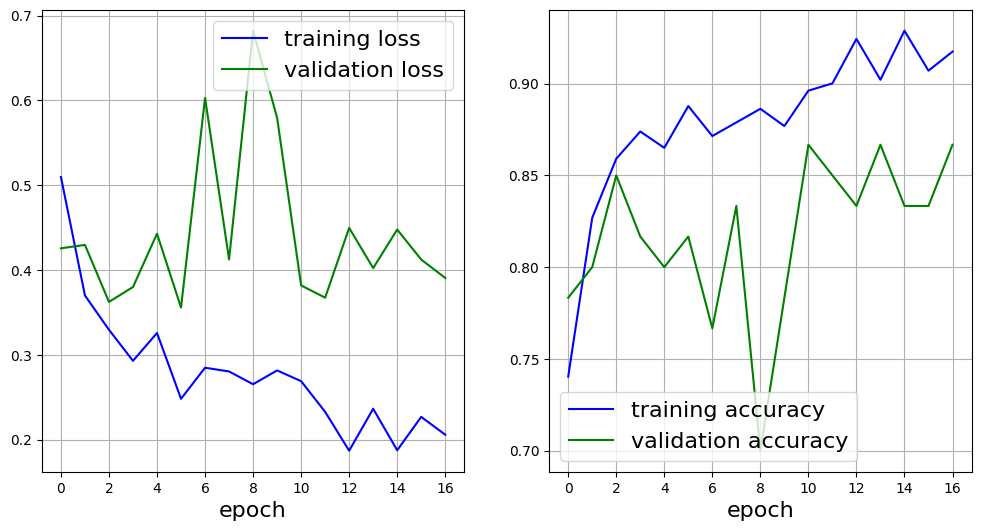

In [228]:
#Plot the loss and accuracy results
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-g', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

In [225]:
test_accuracy = 0

for data in test_loader:
    #Get data and labels
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #Forward pass
    outputs = pre_trained_model(inputs).flatten()
    loss = nnF.binary_cross_entropy(outputs, labels.float())
    
    #Calculate accuracy
    test_accuracy += (outputs.round() == labels).sum().item()
    
#Calculate average loss and accuracy
test_accuracy /= len(test_loader.dataset)
print(test_accuracy)

0.845
